In [ ]:
#| default_exp tasks

In [ ]:
#| export
import fastcore.all as fc
import torch
from torch.utils.data import DataLoader, IterableDataset

In [ ]:
#| hide
from functools import partial

import matplotlib.pyplot as plt
from torch import nn

In [ ]:
# | export
class DataGenerator(IterableDataset):
    def __init__(self, batch_generator, n_batches=None):
        self.batch_generator = batch_generator
        self.n_batches = n_batches

    def __len__(self): return self.n_batches

    def __iter__(self):
        self.cnt = 0
        return self

    def __next__(self):
        if self.n_batches and self.cnt >= len(self): raise StopIteration
        self.cnt += 1
        return self.batch_generator()
    
    @property
    def task(self): return self.batch_generator


@fc.delegates(DataLoader)
def dataloader(batch_generator, n_batches=None, **kwargs):
    return DataLoader(DataGenerator(batch_generator, n_batches), batch_size=None, **kwargs)


@fc.patch()
def sample(dl: DataLoader): return next(iter(dl))

### Tasks

In [ ]:
# | export
class LinearRegression:
    def __init__(self, bs: int, n_points=30, n_dims=20, std=0.1, sparsity=None, truncated_dims=0, **kwargs):
        """
        Args:
            bs (int): Batch size
            n_points (int, optional): Number of data points in a batch. Defaults to 30.
            n_dims (int, optional): Dimension of each point. Defaults to 20.
            std (float, optional): standard deviation. Defaults to 0.1.
            sparsity (int, optional): Number of non-zero weights in model. Defaults to None.
            truncated_dims (int, optional): Number of dimensions to truncate. Defaults to 0.
        """
        self.bs, self.n_dims, self.std = bs, n_dims, std
        self.sparsity = sparsity if sparsity is not None else n_dims
        # Dynamically updated attributes
        self.truncated_dims = truncated_dims
        self.n_points = n_points

    def __call__(self):
        xs = torch.randn(self.bs, self.n_points, self.n_dims)
        ws = torch.randn(self.bs, self.n_dims, 1)
        mask = self._sparse_mask()
        ws[mask] = 0
        if self.truncated_dims > 0:
            xs[:, :, -self.truncated_dims:] = 0
            ws[:, -self.truncated_dims:] = 0
        ys = torch.bmm(xs, ws).squeeze(-1)
        return xs, ys + self.std * torch.randn_like(ys)

    def _sparse_mask(self):
        mask = torch.ones(self.bs, self.n_dims, dtype=bool)
        idx = torch.multinomial(torch.ones_like(mask, dtype=float), self.sparsity)
        mask.scatter_(1, idx, False)
        return mask

Linear regression

<matplotlib.collections.PathCollection>

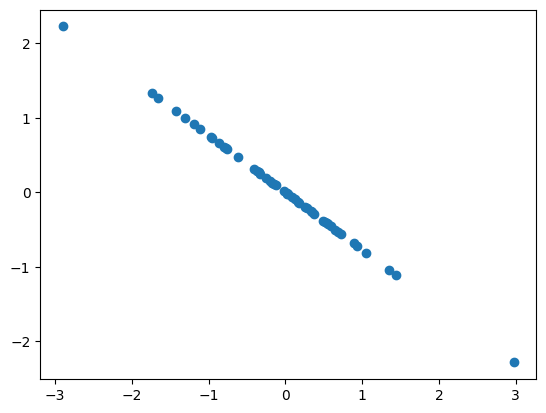

In [ ]:
xb, yb = dataloader(LinearRegression(bs=4, n_points=50, n_dims=1, std=0.0), n_batches=1).sample()
plt.scatter(xb[0], yb[0])

Noisy linear regression

<matplotlib.collections.PathCollection>

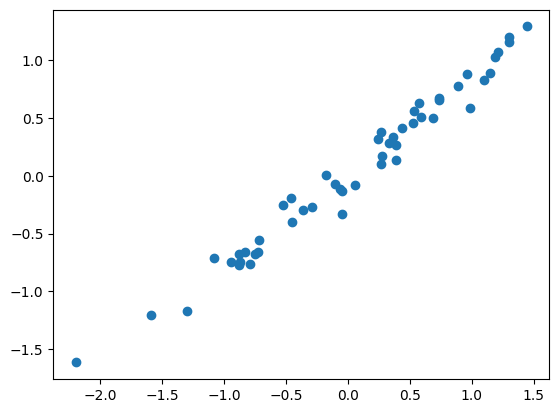

In [ ]:
xb, yb = dataloader(LinearRegression(bs=4, n_points=50, n_dims=1, std=0.1), n_batches=1).sample()
plt.scatter(xb[0], yb[0])

Sparse linear regression. Only subset of weights is non-zero

<matplotlib.collections.PathCollection>

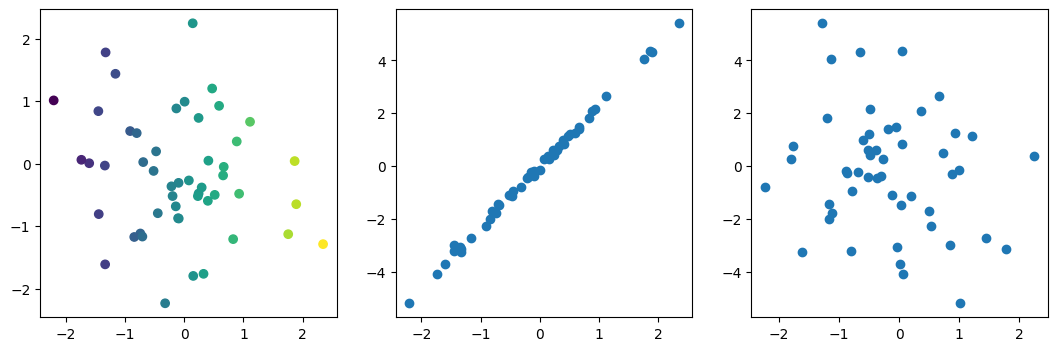

In [ ]:
xb, yb = dataloader(LinearRegression(bs=4, n_points=50, n_dims=2, std=0.1, sparsity=1), n_batches=1).sample()
axes = plt.subplots(ncols=3, figsize=(13,4))[1]
axes[0].scatter(xb[0,:,0], xb[0,:,1], c=yb[0])
axes[1].scatter(xb[0,:,0], yb[0])
axes[2].scatter(xb[0,:,1], yb[0])